In [2]:
import os
from collections import defaultdict
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from graph_generation.generate import synthetic_dir, float_fname
from utils import load_pickle

In [23]:
sns.color_palette()

[(0.2980392156862745, 0.4470588235294118, 0.6901960784313725),
 (0.8666666666666667, 0.5176470588235295, 0.3215686274509804),
 (0.3333333333333333, 0.6588235294117647, 0.40784313725490196),
 (0.7686274509803922, 0.3058823529411765, 0.3215686274509804),
 (0.5058823529411764, 0.4470588235294118, 0.7019607843137254),
 (0.5764705882352941, 0.47058823529411764, 0.3764705882352941),
 (0.8549019607843137, 0.5450980392156862, 0.7647058823529411),
 (0.5490196078431373, 0.5490196078431373, 0.5490196078431373),
 (0.8, 0.7254901960784313, 0.4549019607843137),
 (0.39215686274509803, 0.7098039215686275, 0.803921568627451)]

In [24]:

def get_density(dir_path, indices):
    densities = []
    for i in indices:
        G = load_pickle(os.path.join(dir_path, "G_{}.pkl".format(i)))
        densities.append(G.number_of_edges()/(len(G) * (len(G)-1) / 2))
    return np.mean(densities)


def get_m(dir_path, indices):
    ms = []
    for i in indices:
        G = load_pickle(os.path.join(dir_path, "G_{}.pkl".format(i)))
        ms.append(G.number_of_edges())
    return np.mean(ms)

# graph_colors = {
#     "ER": "tab:blue",
#     "BA": "tab:red",
#     "WS": "tab:orange",
#     "GEO": "tab:green"
# }
graph_colors = {gt: c for gt, c in zip(["ER", "WS", "BA", "GEO"], sns.color_palette())}

# Densities

ER
[0.0992707070707071, 0.20042424242424242, 0.4004222222222221, 0.60069898989899]
['0-1', '0-2', '0-4', '0-6']

BA
[0.03959595959595958, 0.07757575757575758, 0.1486868686868687, 0.2715151515151516, 0.4395959595959598, 0.5042424242424243]
[2, 4, 8, 16, 32, 48]

WS
[0.0808080808080808, 0.1616161616161616, 0.3232323232323232, 0.6464646464646464]
[8, 16, 32, 64]

GEO
[0.10512121212121212, 0.34934141414141406, 0.6211535353535352]
['0-2', '0-4', '0-6']



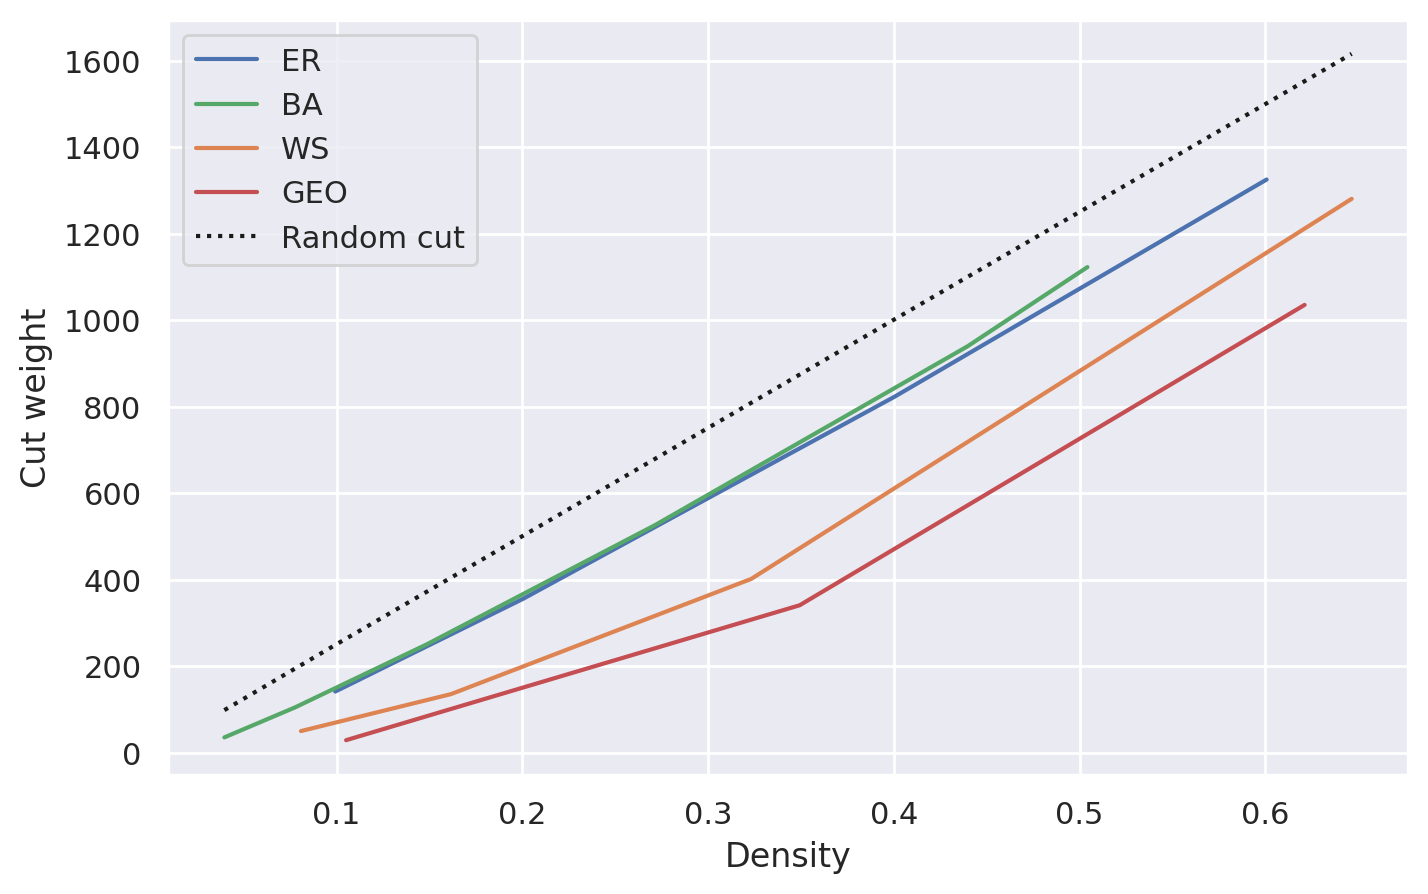

In [30]:
# all by density



graph_types = ["ER", "BA", "WS", "GEO"]
graph_base_dir = {
    "ER": "erdos_renyi_100_{}",
    "BA": "barabasi_albert_100_{}",
    "WS": "watts_strogatz_100_{}_0-2",
    "GEO": "geometric_100_{}"
}
graph_params = {
    "ER": ["0-1", "0-2", "0-4", "0-6"],
    "BA": [2, 4, 8, 16, 32, 48],
    "WS": [8, 16, 32, 64],
    "GEO": ["0-2", "0-4", "0-6"]
} 

random = []
r_densities = []

sns.set()
plt.figure(num=None, figsize=(8, 5), dpi=200, facecolor='w', edgecolor='k')

for gt in graph_types:
    hmetis = []
    densities = []
    r = []
    for p in graph_params[gt]:
        graph_dir = os.path.join(synthetic_dir, graph_base_dir[gt].format(p))
        df = pd.read_csv(os.path.join(graph_dir, "baselines.csv"))
        r.append(np.mean(df["random_2"]))
        hmetis.append(np.mean(df["hmetis_2_1"]))
        densities.append(get_density(graph_dir, range(100)))
    print(gt)
    print(densities)
    print(graph_params[gt])
    print()
    
    if len(random) == 0:
        random = r
        r_densities = densities
    else:
        if densities[-1] > r_densities[-1]:
            r_densities.append(densities[-1])
            random.append(r[-1])
        if densities[0] < r_densities[0]:
            r_densities = [densities[0]] + r_densities
            random = [r[0]] + random
        
   
    plt.plot(densities, hmetis, color=graph_colors[gt], label=gt)

plt.plot(r_densities, random, linestyle="dotted", color="k", label="Random cut")
plt.legend()

plt.title("")
plt.ylabel("Cut weight")
plt.xlabel("Density")

plt.savefig("figures/density_vs_cut.png")
plt.show()

# Size 

In [32]:
from graph_generation.generate import compute_m_ba, compute_radius_geo, float_fname

sizes = [10, 20, 50, 100, 200, 1000, 2000]
d = 0.3
geo_r = 0.36


g_types = {
    "ER": {x: "barabasi_albert_{}_{}".format(x, compute_m_ba(x, d)) for x in sizes},
    "BA": {x: "erdos_renyi_{}_0-3".format(x) for x in sizes},
    "WS": {x: "watts_strogatz_{}_{}_0-4".format(x, round(d * (x-1))) for x in sizes},
    "GEO": {x: "geometric_{}_{}".format(x, float_fname(geo_r)) for x in sizes}
}

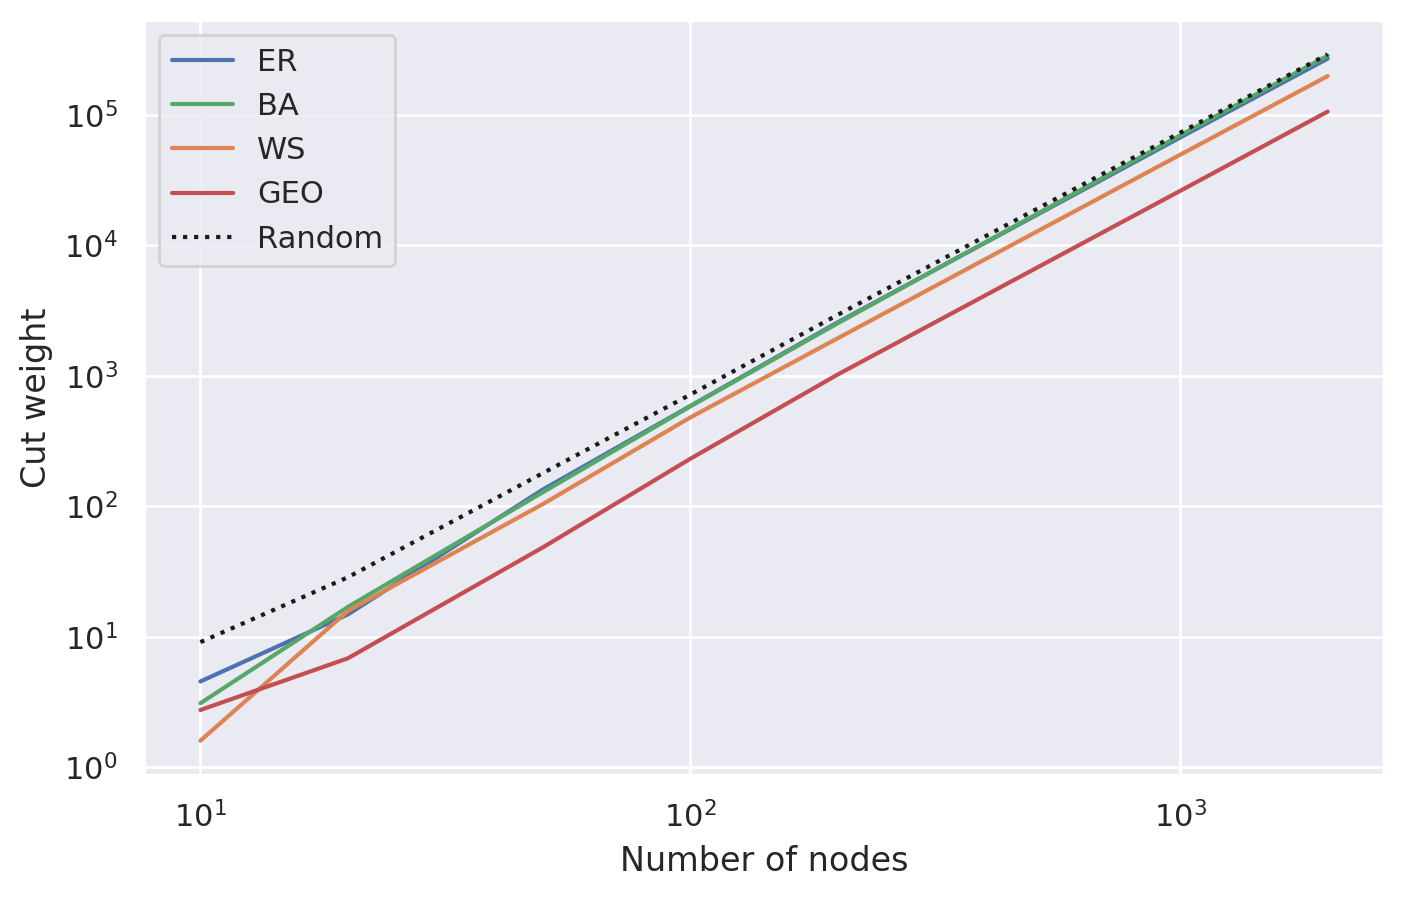

In [38]:
plt.figure(num=None, figsize=(8, 5), dpi=200, facecolor='w', edgecolor='k')


for gt, instances in g_types.items():
    hmetis = []
    r = []
    for size, dir_name in instances.items():
        graph_dir = os.path.join(synthetic_dir, dir_name)
        df = pd.read_csv(os.path.join(graph_dir, "baselines.csv"))
        r.append(np.mean(df["random_2"]))
        hmetis.append(np.mean(df["hmetis_2_1"]))
    

    plt.plot(sizes, hmetis, color=graph_colors[gt], label=gt)

    plt.xscale("log")
    plt.yscale("log")
plt.plot(sizes, r, color="k", linestyle="dotted", label="Random")
plt.legend()


plt.title("")
plt.ylabel("Cut weight")
plt.xlabel("Number of nodes")

plt.savefig("figures/size_vs_cut.png")
plt.show()



In [315]:
df

,Unnamed: 0,kl,greedy,random_2,hmetis_2_5,hmetis_2_5_imbalance,hmetis_2_1,hmetis_2_1_imbalance
0,0,1053.0,1053.0,1546.4,1013.0,0.12,1047.0,0.02
1,1,912.0,912.0,1502.0,904.0,0.12,911.0,0.02
2,2,1010.2,1010.2,1547.2,960.0,0.12,1001.0,0.02
3,3,1278.0,1279.0,1734.2,1247.0,0.12,1276.0,0.02
4,4,1111.0,1111.0,1627.8,1090.0,0.12,1110.0,0.02
...,...,...,...,...,...,...,...,...
95,95,1154.0,1164.4,1637.4,1125.0,0.12,1153.0,0.02
96,96,991.0,991.0,1536.0,981.0,0.12,991.0,0.00
97,97,1092.0,1104.0,1556.6,1050.0,0.12,1089.0,0.02
98,98,1169.0,1169.0,1634.0,1145.0,0.12,1169.0,0.00


# Comparison k

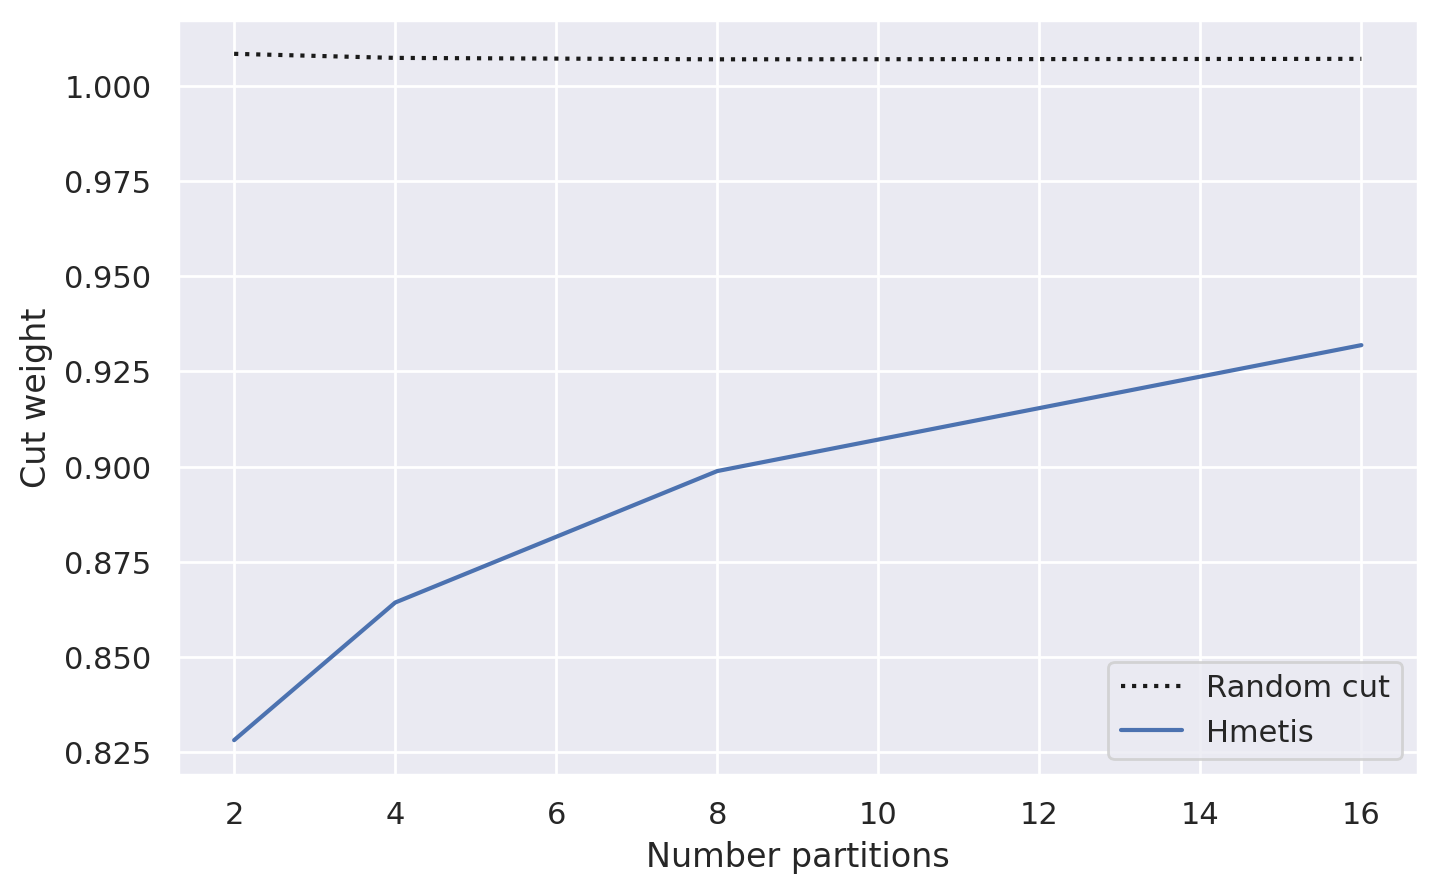

In [34]:
# all by k
import math

# graph_base_dir = "barabasi_albert_2000_367"
# graph_base_dir = "barabasi_albert_2000_367"
#graph_base_dir = "watts_strogatz_100_32_0-1"
graph_base_dir = "erdos_renyi_100_0-4"

ks = [2, 4, 8, 16]

plt.figure(num=None, figsize=(8, 5), dpi=200, facecolor='w', edgecolor='k')

hmetis = []
random = []
graph_dir = os.path.join(synthetic_dir, graph_base_dir)
df = pd.read_csv(os.path.join(graph_dir, "baselines.csv"))
m = get_m(graph_dir, range(20))

def normalize(cut, m, k):
    return cut/(m*(k-1)/k)
    

for k in ks:
    #hmetis.append(np.mean(df["hmetis_{}_1".format(k)])/m)
    hmetis.append(normalize(np.mean(df["hmetis_{}_1".format(k)]), m, k))
    random.append(normalize(np.mean(df["random_{}".format(k)]), m, k))
    #random.append(np.mean(df["random_{}".format(k)])/m)


plt.plot(ks, random, linestyle="dotted", color="k", label="Random cut")
plt.plot(ks, hmetis, color="b", label="Hmetis")
plt.legend()

plt.title("")
plt.ylabel("Cut weight")
plt.xlabel("Number partitions")

plt.savefig("figures/k_vs_cut.png")
plt.show()

# Watts Strogatz parameter investigation

In [36]:
# watts strogatz
size = 100
ms = [8, 16, 32, 64]
ps = [0.1, 0.2, 0.4, 0.8]
plot = ["kl", "greedy", "hmetis_2_1"]
means = defaultdict(lambda: np.empty((4, 4)))

for i, p in enumerate(reversed(ps)):
    for j, m in enumerate(ms):
        graph_dir = "watts_strogatz_{}_{}_{}".format(size, m, float_fname(p))
        df = pd.read_csv(os.path.join(synthetic_dir, graph_dir, "baselines.csv"))
        for metric in plot:
            means[metric][i,j] = np.mean(df[metric])#/df["random_2"])
        means["random"][i,j] = np.mean(df["random_2"])



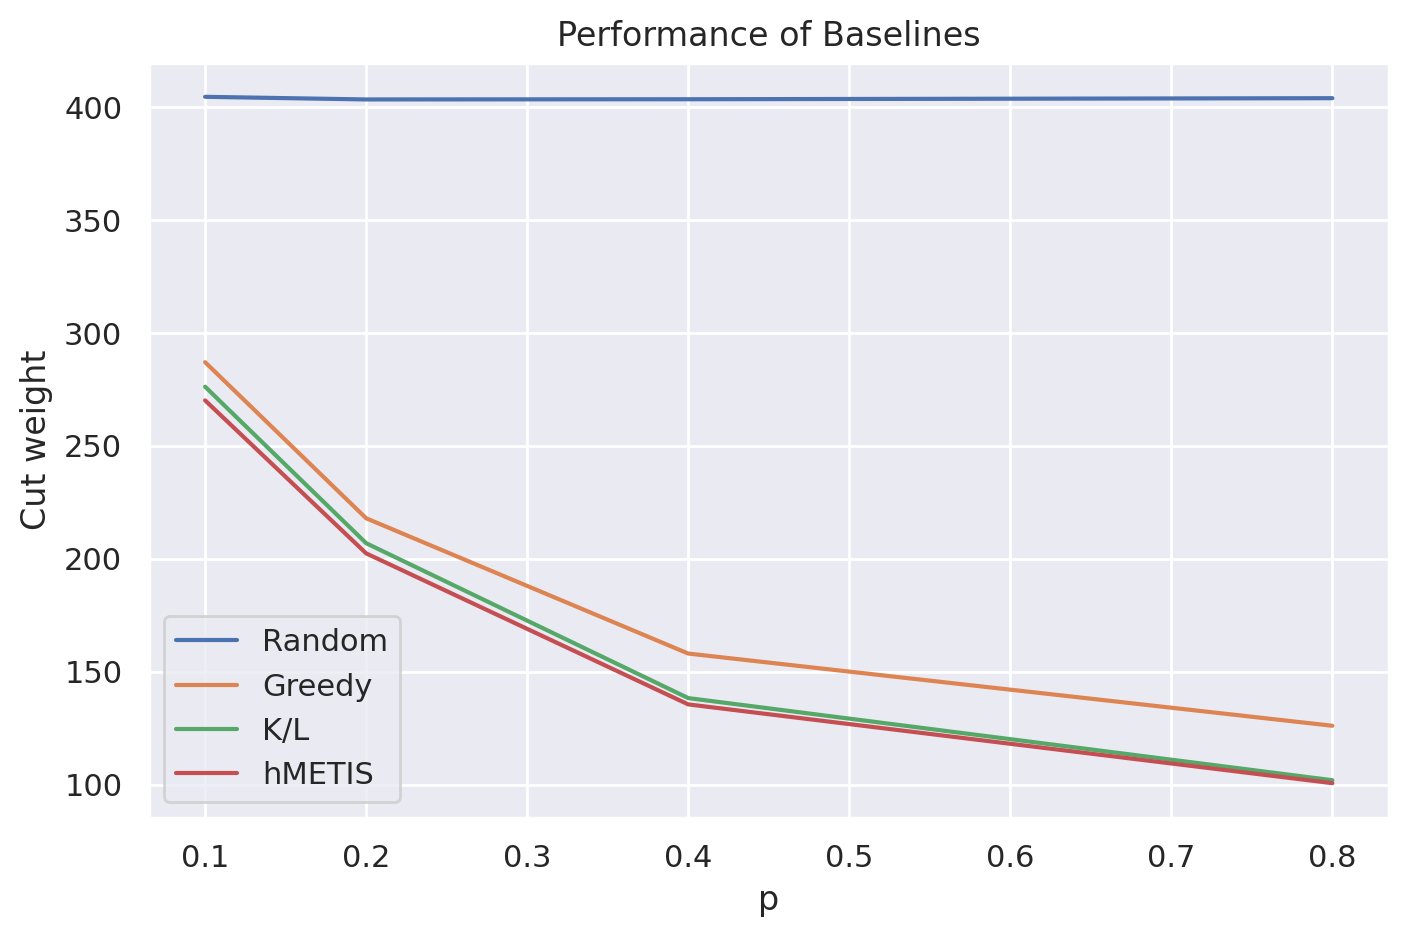

In [37]:
#for j, m in enumerate(ms):
j = 1
m = 16

plt.figure(num=None, figsize=(8, 5), dpi=200, facecolor='w', edgecolor='k')

plt.plot(ps, means["random"][:, j], label="Random")
plt.plot(ps, means["greedy"][:, j], label="Greedy")
plt.plot(ps, means["kl"][:, j], label="K/L")
plt.plot(ps, means["hmetis_2_1"][:, j], label="hMETIS")


#plt.yscale("log")
plt.legend()
plt.title("Performance of Baselines")
plt.ylabel("Cut weight")
plt.xlabel("p")

plt.savefig("figures/watts_strogatz_p_param.png")
plt.show()

# Unused


In [106]:
# erdos renyi

size = 100
ps = [0.1, 0.2, 0.4, 0.6]
data = []
means = defaultdict(list)
plot = ["kl", "greedy", "hmetis_2_1"]
for p in ps:
    graph_dir = "erdos_renyi_{}_{}".format(size, float_fname(p))
    df = pd.read_csv(os.path.join(synthetic_dir, graph_dir, "baselines.csv"))
    for metric in plot:
        means[metric].append(np.mean(df[metric]/df["random_2"]))
    means["random"].append(np.mean(df["random_2"]))



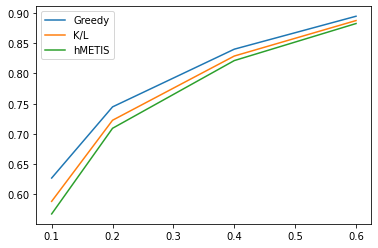

In [107]:
plt.plot(ps, means["greedy"], label="Greedy")
plt.plot(ps, means["kl"], label="K/L")
plt.plot(ps, means["hmetis_2_1"], label="hMETIS")

#plt.yscale("log")
plt.legend()

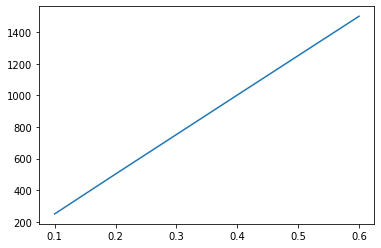

In [108]:
plt.plot(ps, means["random"], label="Random")


In [50]:
# barabasi albert
size = 100
ms = [2, 4, 8, 16, 32]
means = defaultdict(list)
plot = ["kl", "greedy", "hmetis_2_1"]
for m in ms:
    graph_dir = "barabasi_albert_{}_{}".format(size, m)
    df = pd.read_csv(os.path.join(synthetic_dir, graph_dir, "baselines.csv"))
    for metric in plot:
        means[metric].append(np.mean(df[metric]))
    means["random"].append(np.mean(df["random_2"]))




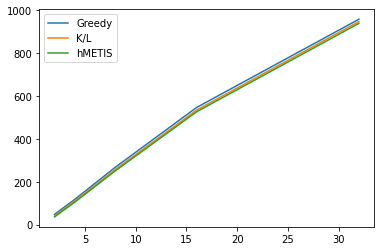

In [51]:
plt.plot(ms, means["greedy"], label="Greedy")
plt.plot(ms, means["kl"], label="K/L")
plt.plot(ms, means["hmetis_2_1"], label="hMETIS")

#plt.yscale("log")
plt.legend()

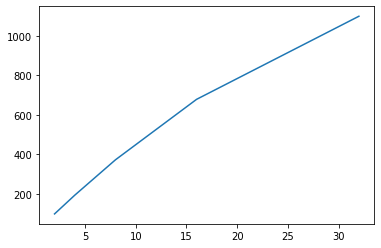

In [52]:
plt.plot(ms, means["random"])

In [100]:
# geometric
size = 100
rs = [0.2, 0.4, 0.6]
means = defaultdict(list)
plot = ["kl", "greedy", "hmetis_2_1"]
for r in rs:
    graph_dir = "geometric_{}_{}".format(size, float_fname(r))
    df = pd.read_csv(os.path.join(synthetic_dir, graph_dir, "baselines.csv"))
    for metric in plot:
        means[metric].append(np.mean(df[metric]/df["random_2"]))
    means["random"].append(np.mean(df["random_2"]))



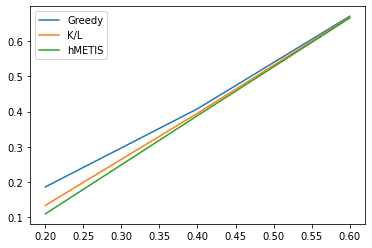

In [101]:
plt.plot(rs, means["greedy"], label="Greedy")
plt.plot(rs, means["kl"], label="K/L")
plt.plot(rs, means["hmetis_2_1"], label="hMETIS")

#plt.yscale("log")
plt.legend()